# 연직단면도 그리기
- 간단한 vertical cross section 그리기
- 대기의 연직 구조를 파악하는 데 도움이 됨
- https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py 참조

In [1]:
# 자료 내려받기
from siphon.simplewebservice.wyoming import WyomingUpperAir
import cdsapi

# 자료 다루기
from datetime import datetime
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
from metpy.interpolate import cross_section
from scipy.ndimage import gaussian_filter

# 그림 그리기
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [16]:
def plot_maxmin_points(ax, lon, lat, domain, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        if (lon[mxx[i], mxy[i]] > domain[0]) & (lon[mxx[i], mxy[i]] < domain[1]) & (lat[mxx[i], mxy[i]] > domain[2]) & (lat[mxx[i], mxy[i]] < domain[3]):
            ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
            ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int32(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
            ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
            ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)

In [3]:
ds2

<xarray.Dataset>
Dimensions:        (latitude: 181, longitude: 360)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
    isobaricInhPa  float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     datetime64[ns] ...
Data variables: (12/16)
    gh             (latitude, longitude) float32 ...
    t              (latitude, longitude) float32 ...
    r              (latitude, longitude) float32 ...
    tcc            (latitude, longitude) float32 ...
    q              (latitude, longitude) float32 ...
    w              (latitude, longitude) float32 ...
    ...             ...
    clwmr          (latitude, longitude) float32 ...
    icmr           (latitude, longitude) float32 ...
    rwmr           (latitude, longitude) float32 ...
    snmr           (latitude, longitude) float32 ...
    grle           (latitude, longitude) float32 ...
    o3mr           (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-11-12T08:38 GRIB to CDM+CF via cfgrib-0.9.9...

In [6]:
# Read data
ds1 = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2',
                      engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'meanSea'},'indexpath': ''})
lvl = 500
ds2 = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level':lvl}})



# Select and grab data, at/lon values 
pres = ds1['prmsl'].sel(latitude=slice(90,0), longitude=slice(60,201))
lats = pres.latitude.data
lons = pres.longitude.data
gh = ds2['gh'].sel(latitude=slice(90,0), longitude=slice(60,201))
t = ds2['t'].sel(latitude=slice(90,0), longitude=slice(60,201))
u = ds2['u'].sel(latitude=slice(90,0), longitude=slice(60,201))
v = ds2['v'].sel(latitude=slice(90,0), longitude=slice(60,201))


# Select and grab surface pressure, smooth with gaussian_filter
pres = gaussian_filter(pres.data, sigma=3.0) / 100. * units('hPa')
gh = gaussian_filter(gh.data, sigma=3.0) *units('m')
u = gaussian_filter(u.data, sigma=3.0) * units('m/s')
v = gaussian_filter(v.data, sigma=3.0) * units('m/s')
t = gaussian_filter(t.data, sigma=3.0) * units('K')
wind = mpcalc.wind_speed(u, v).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds1.time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

# 지상, 상층 일기도 그리기

Text(0.5, 0.98, 'Valid Time: 2021-09-21 00:00:00')

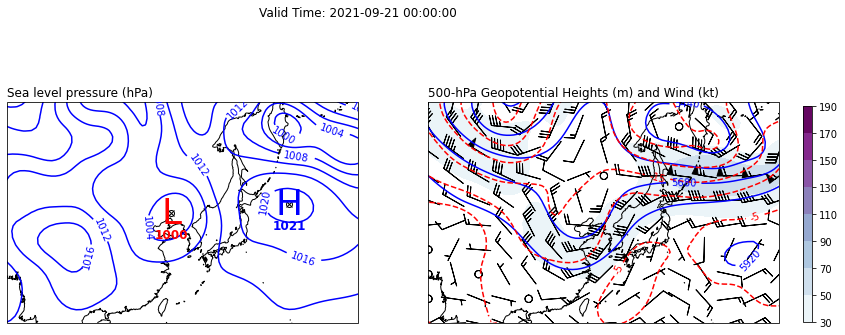

In [17]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(13, 6))
ax = fig.add_subplot(121, projection=mapcrs)

## Surface
domain = [90, 160, 20, 60]
ax.set_extent(domain, ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(ax, lons, lats, domain, pres.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(ax, lons, lats, domain, pres.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
ax.set_title('Sea level pressure (hPa)',
           loc='left')

## pressure level
ax2 = fig.add_subplot(122, projection=mapcrs)
ax2.set_extent(domain, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_wind = np.arange(30, 200, 20)
cf = ax2.contourf(lons, lats, wind, clevs_wind, cmap=plt.cm.BuPu,
                 transform=datacrs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.25, 0.01, 0.5])
fig.colorbar(cf, orientation='vertical', shrink=0.5, cax=cbar_ax)

# Plot 500-hPa Geopotential Heights in meters
clevs_gh = np.arange(40, 15000, 120)
cs = ax2.contour(lons, lats, gh, clevs_gh, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa temperatue in degC
clevs_t = np.arange(-60, 5, 5)
cs = ax2.contour(lons, lats, t.to('degC'), clevs_t, colors='red', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax2.barbs(lons, lats, u.to('kt').m, v.to('kt').m, pivot='middle',regrid_shape=10, 
         color='black',  transform=datacrs)

# Make some nice titles for the plot (one right, one left)
ax2.set_title('500-hPa Geopotential Heights (m) and Wind (kt)'
              ,loc='left')
fig.suptitle('Valid Time: {}'.format(vtime))

# Adjust image and show
#fig.tight_layout(rect=[0, 0, 0.975, 0.99])

In [25]:
gh = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'gh'}})
u = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'u'}})
v = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'v'}})
t = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'t'}})
q = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'q'}})

In [58]:
ds = gh
for var in [u,v,t,q]:
    ds = ds.merge(var)
ds = ds.sel(isobaricInhPa=[1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,  650.,
        600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,  200.,  150.,
        100.])

# 연직단면도 그리기

In [59]:
data = ds.metpy.parse_cf()
start = (45., 120.)
end = (25., 120.)
cross = cross_section(data, start, end)
cross.set_coords(('latitude','longitude'))

C:\Users\DongGyu_Hyeon\miniconda3\envs\anl\lib\site-packages\metpy\xarray.py:349: UserWarning: More than one time coordinate present for variable "gh".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


<xarray.Dataset>
Dimensions:        (isobaricInhPa: 21, index: 100)
Coordinates:
    time           datetime64[ns] 2021-09-21
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 150.0 100.0
    valid_time     datetime64[ns] 2021-09-21
    metpy_crs      object Projection: latitude_longitude
    longitude      (index) float64 120.0 120.0 120.0 120.0 ... 120.0 120.0 120.0
    latitude       (index) float64 45.0 44.8 44.6 44.39 ... 25.61 25.4 25.2 25.0
  * index          (index) int32 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    gh             (isobaricInhPa, index) float64 26.69 23.53 ... 1.668e+04
    u              (isobaricInhPa, index) float64 -2.813 -2.144 ... -4.279
    v              (isobaricInhPa, index) float64 -7.336 -7.703 ... -4.68 -4.385
    t              (isobaricInhPa, index) float64 287.6 287.5 ... 198.7 198.9
    q              (isobaricInhPa, index) float64 0.009437 ... 3.244e-06
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-11-12T09:00 GRIB to CDM+CF via cfgrib-0.9.9...

In [60]:
cross['Potential_temperature'] = mpcalc.potential_temperature(
    cross['isobaricInhPa'],
    cross['t']
)
cross['Relative_humidity'] = mpcalc.relative_humidity_from_specific_humidity(
    cross['isobaricInhPa'],
    cross['t'],
    cross['q']
)
cross['u_wind'] = cross['u'].metpy.convert_units('knots')
cross['v_wind'] = cross['v'].metpy.convert_units('knots')
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(
    cross['u_wind'],
    cross['v_wind']
)

print(cross)

<xarray.Dataset>
Dimensions:                (isobaricInhPa: 21, index: 100)
Coordinates:
    time                   datetime64[ns] 2021-09-21
    step                   timedelta64[ns] 00:00:00
  * isobaricInhPa          (isobaricInhPa) float64 1e+03 975.0 ... 150.0 100.0
    valid_time             datetime64[ns] 2021-09-21
    metpy_crs              object Projection: latitude_longitude
    longitude              (index) float64 120.0 120.0 120.0 ... 120.0 120.0
    latitude               (index) float64 45.0 44.8 44.6 ... 25.4 25.2 25.0
  * index                  (index) int32 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    gh                     (isobaricInhPa, index) float64 26.69 ... 1.668e+04
    u                      (isobaricInhPa, index) float64 -2.813 ... -4.279
    v                      (isobaricInhPa, index) float64 -7.336 ... -4.385
    t                      (isobaricInhPa, index) float64 287.6 287.5 ... 198.9
    q                      (isobaricInhPa, index)

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_16648/31604347.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 150, -100))


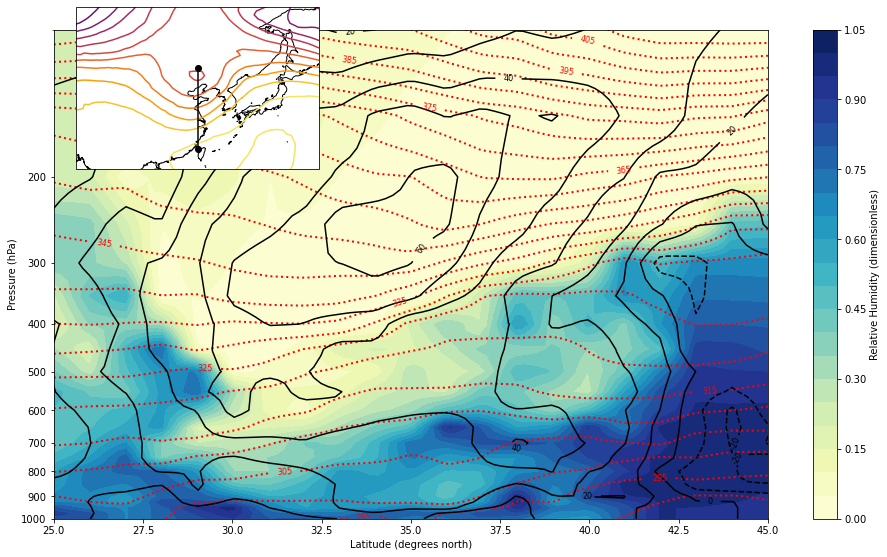

In [61]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['latitude'], cross['isobaricInhPa'][::-1], cross['Relative_humidity'][::-1,:],
                         levels=np.arange(0, 1.1, .05), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['latitude'], cross['isobaricInhPa'][::-1], cross['Potential_temperature'][::-1,:],
                           levels=np.arange(250, 450, 5), colors='r', linestyles='dotted', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='r', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

wind_contour = ax.contour(cross['latitude'], cross['isobaricInhPa'][::-1],
               cross['n_wind'][::-1,:], levels=np.arange(-50,150,10), colors='k')
wind_contour.clabel(wind_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)


# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 150, -100))
ax.set_ylim(cross['isobaricInhPa'].max(), cross['isobaricInhPa'].min())
ax.set_yticks(np.arange(1000, 150, -100))

# Define the CRS and inset axes
#data_crs = data['z'].metpy.cartopy_crs
datacrs = ccrs.PlateCarree()
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=datacrs)
ax_inset.set_extent([90, 150, 20, 60], datacrs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['longitude'].sel(longitude=slice(60,201)), data['latitude'].sel(latitude=slice(90,0)),
                 data['gh'].sel(isobaricInhPa=500., latitude=slice(90,0), longitude=slice(60,201)),
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = datacrs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
#ax.set_title('NARR Cross-Section \u2013 {} to {} \u2013 Valid: {}\n'
#             'Potential Temperature (K), Tangential/Normal Winds (knots), '
#             'Relative Humidity (dimensionless)\n'
#             'Inset: Cross-Section Path and 500 hPa Geopotential Height'.format(
#                 start, end, cross['time'].dt.strftime('%Y-%m-%d %H:%MZ').item()))
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Latitude (degrees north)')
rh_colorbar.set_label('Relative Humidity (dimensionless)')

plt.show()